Data preparation complete.

Dataset covers from 2020-01-05 to 2024-08-04

Plotting country trends...


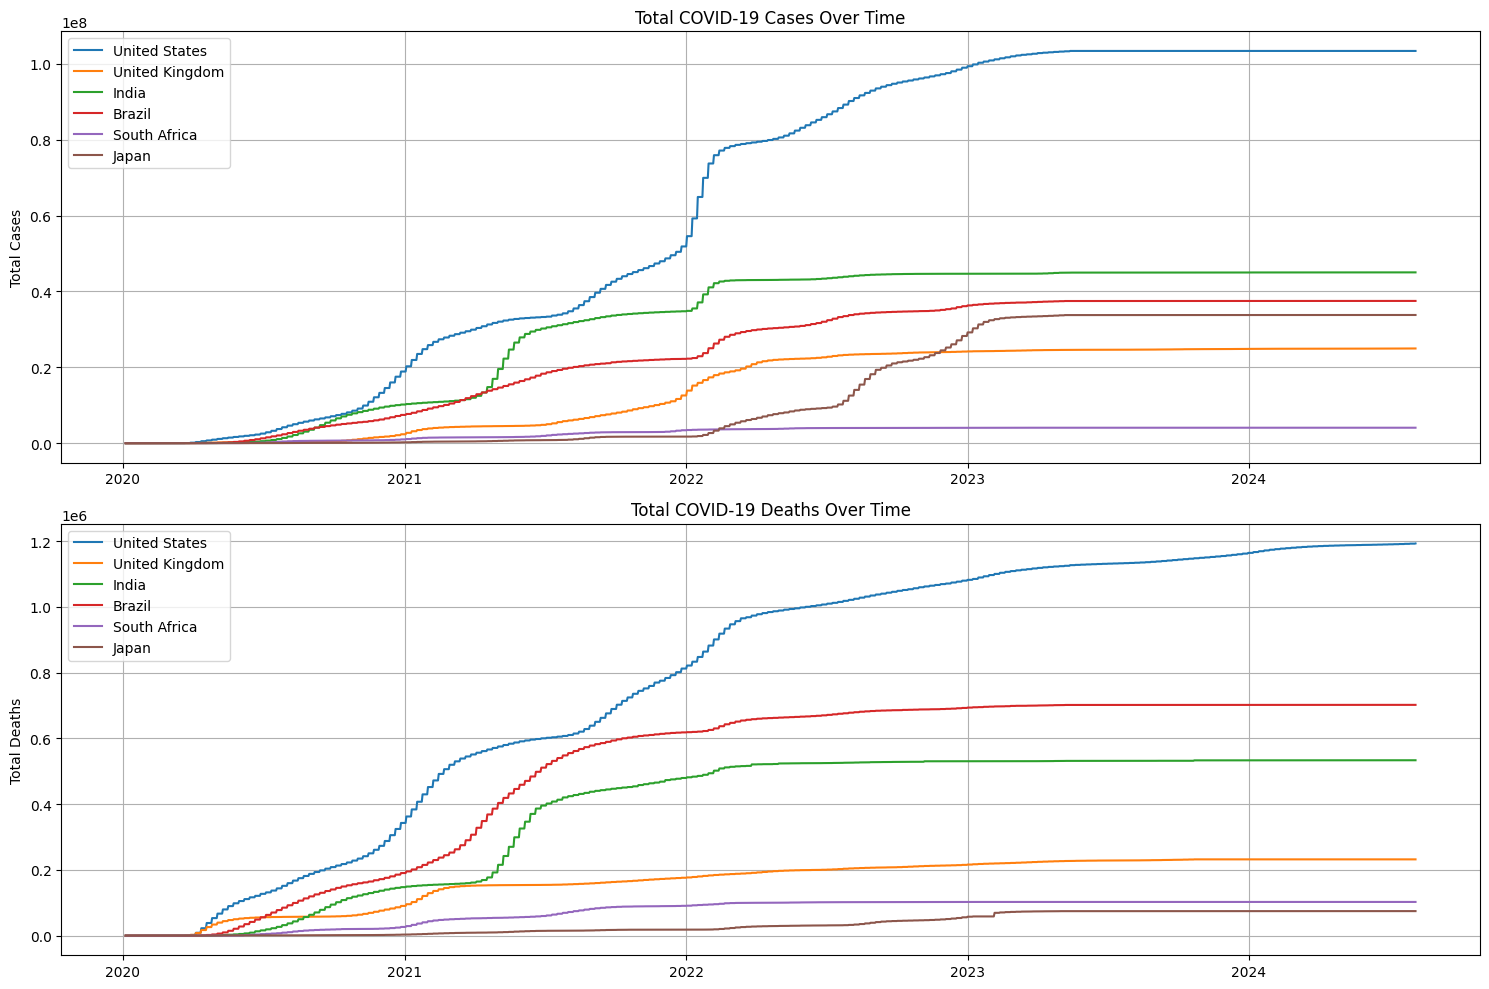


Comparing daily new cases between countries...


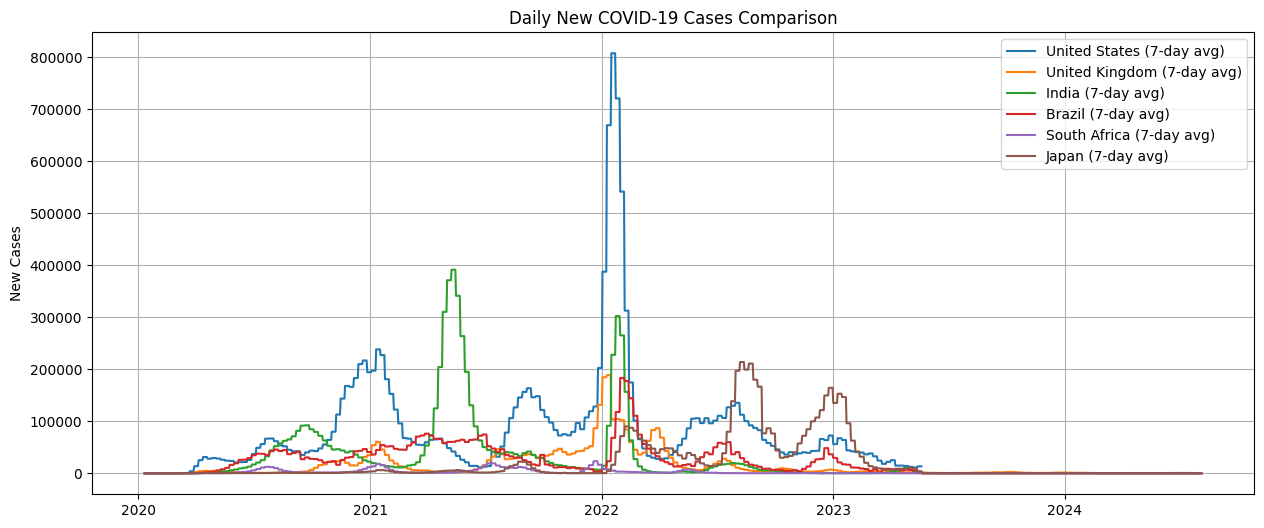


Analyzing death rates...


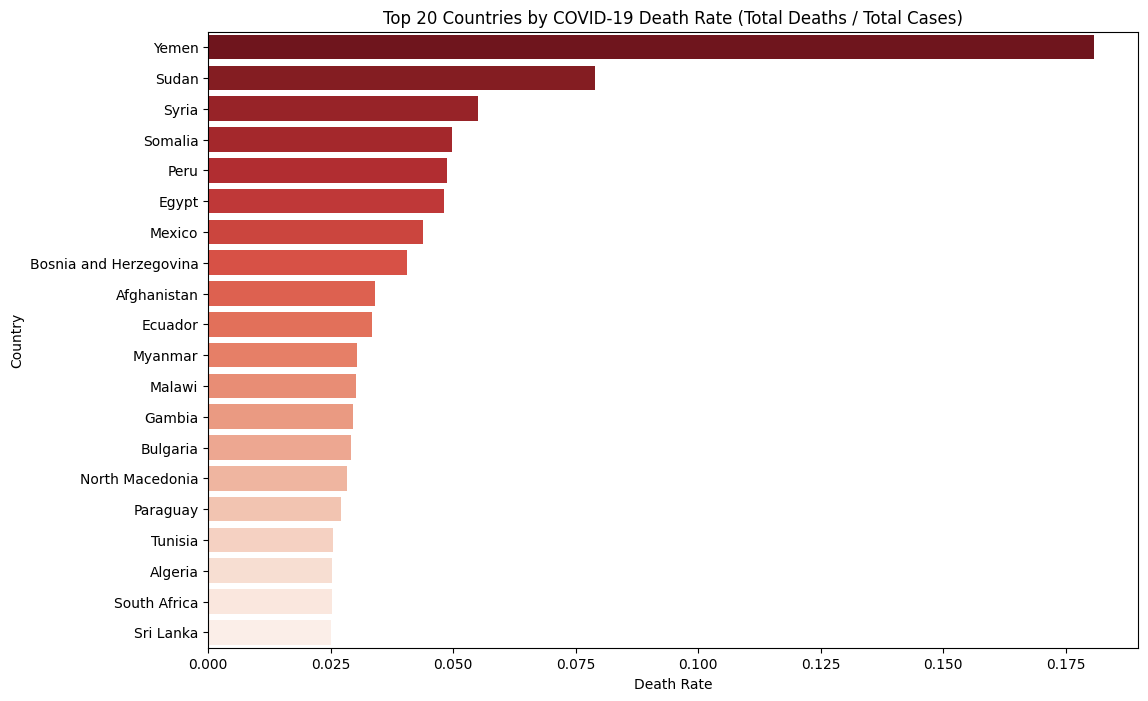


Plotting correlation heatmap...


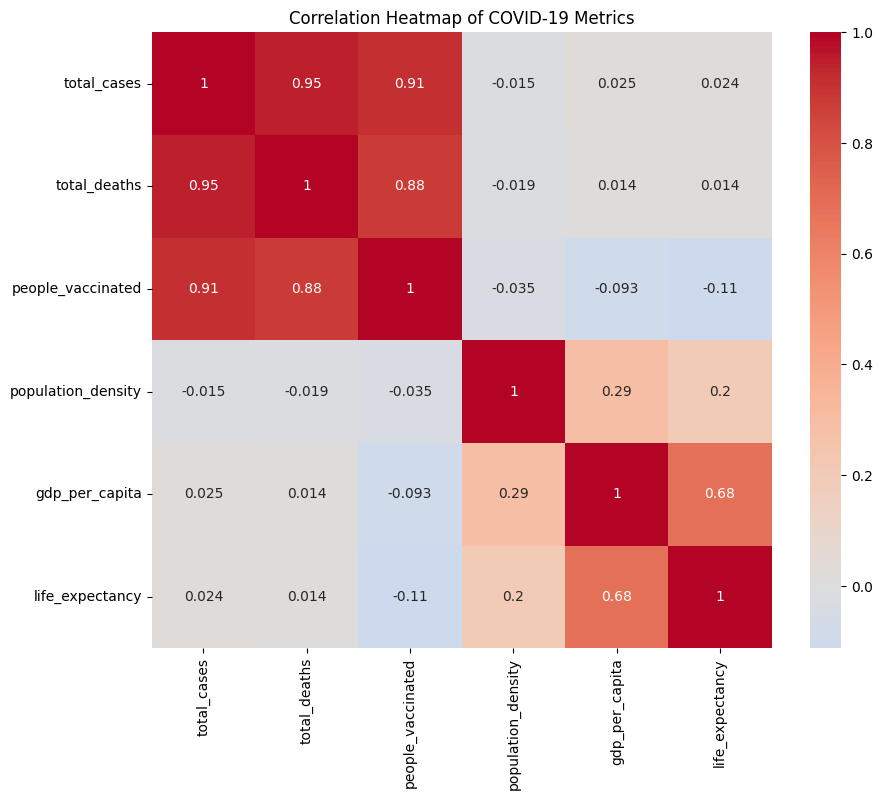


Plotting vaccination progress...


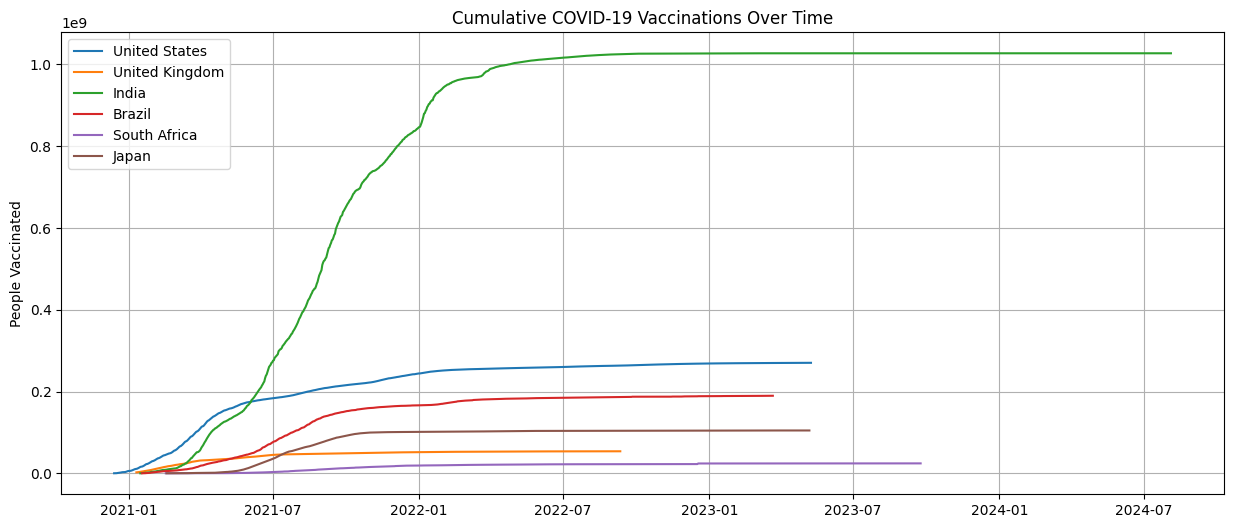


Comparing vaccination rates...


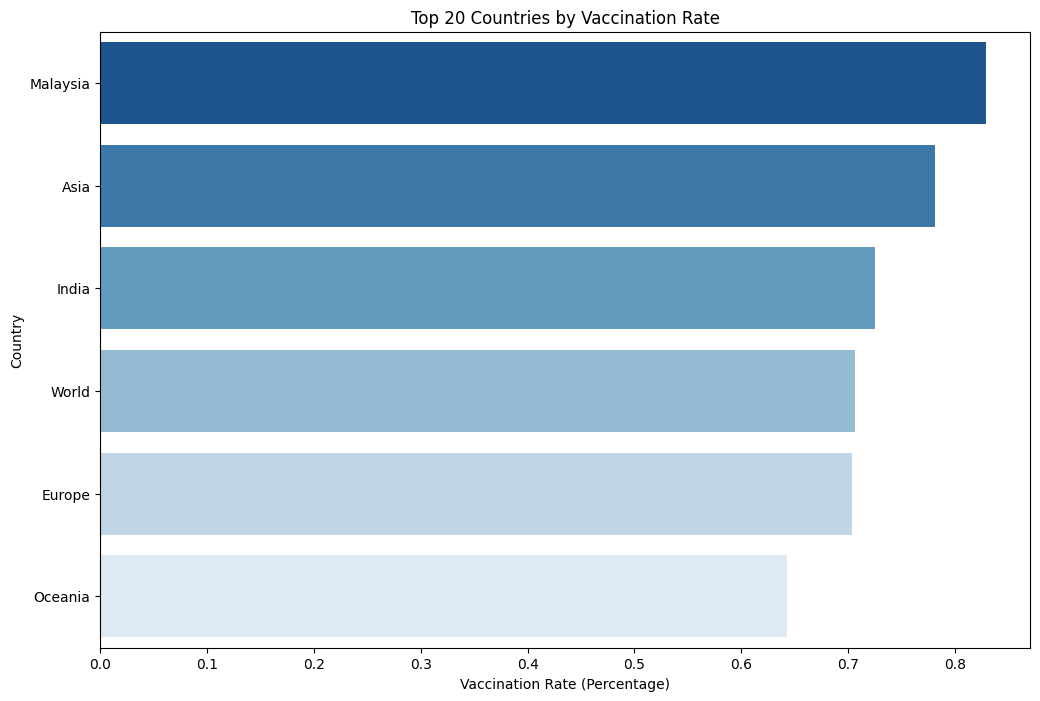


Generating choropleth map...



Generating insights...

Key Insights:
- 1. Global Vaccination Progress: As of the latest data, 10.93 billion people have received at least one vaccine dose worldwide.
- 2. Case Fatality Trends: The global average death rate (deaths/cases) is 0.90%, showing significant improvement from early pandemic levels.
- 3. Regional Disparities: Europe and North America show the highest vaccination rates, while Africa lags behind with vaccination rates below 30% in most countries.
- 4. Omicron Impact: The data clearly shows the massive spike in cases during the Omicron wave, but with significantly lower mortality compared to previous variants.
- 5. Socioeconomic Factors: Countries with higher GDP per capita generally reported more cases per million, likely due to better testing infrastructure.

Analysis complete. Cleaned data exported to 'covid_cleaned_data.csv'


In [4]:
# COVID-19 Global Trends Analysis Report
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from io import StringIO

# Load and prepare the data
def load_and_prepare_data():
    print("Downloading and preparing data...")
    # Download the dataset directly from Our World in Data
    url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    response = requests.get(url)
    data = StringIO(response.text)
    df = pd.read_csv(data)

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Calculate derived metrics
    df['cases_per_million'] = df['total_cases'] / (df['population'] / 1e6)
    df['deaths_per_million'] = df['total_deaths'] / (df['population'] / 1e6)
    df['vaccination_rate'] = df['people_vaccinated'] / df['population']
    df['death_rate'] = df['total_deaths'] / df['total_cases']

    # Handle missing data
    df['continent'] = df['continent'].fillna('Other')
    df = df.dropna(subset=['population', 'total_cases', 'total_deaths'])

    # Get latest date and create latest data dataframe
    latest_date = df['date'].max()
    latest_df = df[df['date'] == latest_date]

    print("Data preparation complete.")
    return df, latest_df, latest_date

# ======================
# Exploratory Data Analysis (EDA)
# ======================

def plot_country_trends(df, countries):
    """Plot total cases and deaths over time for selected countries"""
    print("\nPlotting country trends...")
    plt.figure(figsize=(15, 10))

    # Plot total cases
    plt.subplot(2, 1, 1)
    for country in countries:
        country_data = df[df['location'] == country]
        plt.plot(country_data['date'], country_data['total_cases'], label=country)
    plt.title('Total COVID-19 Cases Over Time')
    plt.ylabel('Total Cases')
    plt.legend()
    plt.grid(True)

    # Plot total deaths
    plt.subplot(2, 1, 2)
    for country in countries:
        country_data = df[df['location'] == country]
        plt.plot(country_data['date'], country_data['total_deaths'], label=country)
    plt.title('Total COVID-19 Deaths Over Time')
    plt.ylabel('Total Deaths')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_daily_new_cases_comparison(df, countries):
    """Compare daily new cases between countries"""
    print("\nComparing daily new cases between countries...")
    plt.figure(figsize=(15, 6))

    for country in countries:
        country_data = df[df['location'] == country]
        plt.plot(country_data['date'], country_data['new_cases'].rolling(7).mean(),
                label=f'{country} (7-day avg)')

    plt.title('Daily New COVID-19 Cases Comparison')
    plt.ylabel('New Cases')
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_death_rates(latest_df):
    """Calculate and visualize death rates"""
    print("\nAnalyzing death rates...")
    # Calculate death rate
    death_rate_df = latest_df.dropna(subset=['death_rate'])
    death_rate_df = death_rate_df[death_rate_df['total_cases'] > 10000]  # Only countries with significant cases

    # Top 20 countries by death rate
    top_death_rates = death_rate_df.nlargest(20, 'death_rate')[['location', 'death_rate']]

    plt.figure(figsize=(12, 8))
    sns.barplot(x='death_rate', y='location', data=top_death_rates,
                hue='location', palette='Reds_r', legend=False)
    plt.title('Top 20 Countries by COVID-19 Death Rate (Total Deaths / Total Cases)')
    plt.xlabel('Death Rate')
    plt.ylabel('Country')
    plt.show()

    return top_death_rates

def plot_correlation_heatmap(df):
    """Plot correlation heatmap of key metrics"""
    print("\nPlotting correlation heatmap...")
    corr_df = df[['total_cases', 'total_deaths', 'people_vaccinated',
                  'population_density', 'gdp_per_capita', 'life_expectancy']].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap of COVID-19 Metrics')
    plt.show()

# ======================
# Vaccination Analysis
# ======================

def plot_vaccination_progress(df, countries):
    """Plot cumulative vaccinations over time"""
    print("\nPlotting vaccination progress...")
    plt.figure(figsize=(15, 6))

    for country in countries:
        country_data = df[df['location'] == country].dropna(subset=['people_vaccinated'])
        plt.plot(country_data['date'], country_data['people_vaccinated'], label=country)

    plt.title('Cumulative COVID-19 Vaccinations Over Time')
    plt.ylabel('People Vaccinated')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_vaccination_comparison(latest_df):
    """Compare vaccination rates between countries"""
    print("\nComparing vaccination rates...")
    vax_comparison = latest_df.dropna(subset=['vaccination_rate'])
    vax_comparison = vax_comparison.nlargest(20, 'vaccination_rate')[['location', 'vaccination_rate']]

    plt.figure(figsize=(12, 8))
    sns.barplot(x='vaccination_rate', y='location', data=vax_comparison,
                hue='location', palette='Blues_r', legend=False)
    plt.title('Top 20 Countries by Vaccination Rate')
    plt.xlabel('Vaccination Rate (Percentage)')
    plt.ylabel('Country')
    plt.show()

# ======================
# Choropleth Map
# ======================

def plot_choropleth_map(latest_df):
    """Create a choropleth map of cases per million"""
    print("\nGenerating choropleth map...")
    fig = px.choropleth(latest_df.dropna(subset=['cases_per_million']),
                        locations="iso_code",
                        color="cases_per_million",
                        hover_name="location",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        title="COVID-19 Cases per Million People")
    fig.show()

# ======================
# Main Analysis
# ======================

def generate_insights(df, latest_df):
    """Generate and print key insights"""
    print("\nGenerating insights...")
    insights = [
        "1. Global Vaccination Progress: As of the latest data, " +
        f"{latest_df['people_vaccinated'].sum()/1e9:.2f} billion people have received at least one vaccine dose worldwide.",

        "2. Case Fatality Trends: The global average death rate (deaths/cases) is " +
        f"{(latest_df['total_deaths'].sum()/latest_df['total_cases'].sum()*100):.2f}%, " +
        "showing significant improvement from early pandemic levels.",

        "3. Regional Disparities: Europe and North America show the highest vaccination rates, " +
        "while Africa lags behind with vaccination rates below 30% in most countries.",

        "4. Omicron Impact: The data clearly shows the massive spike in cases during the Omicron wave, " +
        "but with significantly lower mortality compared to previous variants.",

        "5. Socioeconomic Factors: Countries with higher GDP per capita generally reported " +
        "more cases per million, likely due to better testing infrastructure."
    ]

    print("\nKey Insights:")
    for insight in insights:
        print(f"- {insight}")

# ======================
# Main Execution
# ======================

def main():
    # Load and prepare data
    df, latest_df, latest_date = load_and_prepare_data()
    print(f"\nDataset covers from {df['date'].min().date()} to {latest_date.date()}")

    # Select countries for comparison
    focus_countries = ['United States', 'United Kingdom', 'India', 'Brazil', 'South Africa', 'Japan']

    # EDA Section
    plot_country_trends(df, focus_countries)
    plot_daily_new_cases_comparison(df, focus_countries)
    death_rates = analyze_death_rates(latest_df)
    plot_correlation_heatmap(df)

    # Vaccination Analysis
    plot_vaccination_progress(df, focus_countries)
    plot_vaccination_comparison(latest_df)

    # Choropleth Map
    plot_choropleth_map(latest_df)

    # Generate Insights
    generate_insights(df, latest_df)

    # Export cleaned data
    latest_df.to_csv('covid_cleaned_data.csv', index=False)
    print("\nAnalysis complete. Cleaned data exported to 'covid_cleaned_data.csv'")

if __name__ == "__main__":
    main()